In [1]:
from typing import Final, Optional
import cv2 as OpenCV
from matplotlib import pyplot as plt
import uuid
import numpy as np

In [2]:
class Image:
    def __init__(self, img_id, rgb_image, gray_image, keypoints, descriptors, path):
        self.img_id: int = int(img_id)
        self.unique_id: uuid = uuid.uuid4()
        self.rgb_image: Image = rgb_image
        self.gray_image: Image = gray_image
        self.keypoints: list[OpenCV.KeyPoint] = keypoints
        self.descriptors: np.ndarray = descriptors
        self.path: str = path

    @property
    def length(self):
        return f"{len(self.keypoints)}" if len(self.keypoints) == len(self.descriptors) else f"{len(self.keypoints)}, {len(self.descriptors)}"
    
    def draw_sift_features(self):
        image_with_sift = OpenCV.drawKeypoints(self.rgb_image, self.keypoints, None, flags=OpenCV.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(image_with_sift)
        plt.title("Image with SIFT Features")
        plt.axis('off')
        plt.show()

    def display_rgb_image(self, title: Optional[str] = None):
        image = self.rgb_image
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.axis('off')
        plt.show()

    def display_gray_image(self, title: Optional[str] = None):
        image = self.gray_image
        plt.gray()
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.axes('off')
        plt.show()

        
    def __repr__(self):
        return f"Image({self.img_id})"
    
    def __str__(self):
        return self.__repr__()
    
    def __eq__(self, other):
        return self.unique_id == other.unique_id
    
    def __hash__(self):
        return hash(self.img_id)
    
    def __getstate__(self):
        state = self.__dict__.copy()
        state['keypoints'] = [tuple(k.pt) + (k.size, k.angle, k.response, k.octave, k.class_id) for k in self.keypoints]
        return state
    
    def __setstate__(self, state):
        state['keypoints'] = [OpenCV.KeyPoint(x, y, size, angle, response, octave, class_id) for x, y, size, angle, response, octave, class_id in state['keypoints']]
        self.__dict__ = state

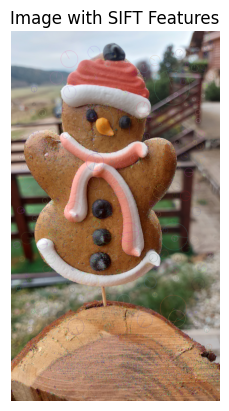

In [3]:
image_path = f"data/snow-man/images/1.jpg"
rgb_image = OpenCV.cvtColor(OpenCV.imread(image_path), OpenCV.COLOR_BGR2RGB)
gray_image = OpenCV.cvtColor(rgb_image, OpenCV.COLOR_RGB2GRAY)
image = Image(1, rgb_image, gray_image, [], [], image_path)

sift = OpenCV.SIFT_create()

keypoints: list[OpenCV.KeyPoint]
descriptors: np.ndarray
keypoints, descriptors = sift.detectAndCompute(image.gray_image, None)
image.keypoints = keypoints
image.descriptors = descriptors

image.draw_sift_features()

In [ ]:
def segment_foreground(image: Image, iterations=5) -> Image:
    mask = np.zeros(image.rgb_image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (50, 50, 450, 290)  # You need to provide a bounding box for the object of interest
    OpenCV.grabCut(image.rgb_image, mask, rect, bgdModel, fgdModel, iterations, OpenCV.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    segmented_image = image.rgb_image * mask2[:, :, np.newaxis]
    
    gray_image = OpenCV.cvtColor(segmented_image, OpenCV.COLOR_RGB2GRAY)
    segmented_image_obj = Image(image.img_id, segmented_image, gray_image, [], [], image.path)
    
    return segmented_image_obj

# Segment the image
segmented_image = segment_foreground(image)

# Compute SIFT features on the segmented image
keypoints: list[OpenCV.KeyPoint]
descriptors: np.ndarray
keypoints, descriptors = sift.detectAndCompute(segmented_image.gray_image, None)
segmented_image.keypoints = keypoints
segmented_image.descriptors = descriptors

# Draw SIFT features on the segmented image
segmented_image.draw_sift_features()